## Reinforcement Learning (REINFORCE) Tutorial
Used for this tutorial
 * https://towardsdatascience.com/learning-reinforcement-learning-reinforce-with-pytorch-5e8ad7fc7da0

Other interesting links
 * https://towardsdatascience.com/policy-gradient-methods-104c783251e0
 * https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#don-t-let-the-past-distract-you
 * https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py
 * https://towardsdatascience.com/learning-reinforcement-learning-reinforce-with-pytorch-5e8ad7fc7da0
 * https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py
 * https://pytorch.org/docs/stable/distributions.html
 * https://github.com/abhisheksuran/Reinforcement_Learning
 * https://github.com/g6ling/Reinforcement-Learning-Pytorch-Cartpole

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import sys
import torch
from torch import nn
from torch import optim
import pandas as pd

# Set a seed for reproducibility
np.random.seed(123)
torch.manual_seed(123);

## Define the model NN

In [3]:
class policy_estimator(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.n_inputs = 4
        self.n_outputs = 2
        self.HIDDEN_LAYER1 = 16 # Originally 16
        self.HIDDEN_LAYER2 = 16 # Originally 16
        
        # Define network
        self.network = nn.Sequential(
            nn.Linear(self.n_inputs, self.HIDDEN_LAYER1), 
            nn.ReLU(), 
            nn.Linear(self.HIDDEN_LAYER1, self.HIDDEN_LAYER2), 
            nn.ReLU(), 
            nn.Linear(self.HIDDEN_LAYER2, self.n_outputs),
            nn.Softmax(dim=-1))
    
    def predict(self, state):
        action_probs = self.network(torch.FloatTensor(state))
        return action_probs

In [4]:
def discount_rewards(rewards, gamma=0.99):
    r = np.array([gamma**i * rewards[i] for i in range(len(rewards))])
    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]
    return r - r.mean()

In [5]:
def reinforce(env, policy_estimator, num_episodes=2000,
              batch_size=10, gamma=0.99):
    # Set up lists to hold results
    total_rewards = []
    batch_rewards = []
    batch_actions = []
    batch_states = []
    batch_counter = 1
    
    # Define optimizer
    optimizer = optim.Adam(policy_estimator.network.parameters(), lr=0.01)
    my_lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)
    
    action_space = np.arange(env.action_space.n)
    ep = 0
    while ep < num_episodes:
        s_0 = env.reset()
        states = []
        rewards = []
        actions = []
        done = False
        while done == False:
            # Get actions and convert to numpy array
            action_probs = policy_estimator.predict(s_0).detach().numpy()
            action = np.random.choice(action_space,p=action_probs)
            s_1, r, done, _ = env.step(action)
            
            states.append(s_0)
            rewards.append(r)
            actions.append(action)
            s_0 = s_1
            
            # If done, batch data
            if done:
                batch_rewards.extend(discount_rewards(rewards, gamma))
                batch_states.extend(states)
                batch_actions.extend(actions)
                batch_counter += 1
                total_rewards.append(sum(rewards))
                
                # If batch is complete, update network
                if batch_counter == batch_size:
                    optimizer.zero_grad()
                    state_tensor = torch.FloatTensor(batch_states)
                    reward_tensor = torch.FloatTensor(batch_rewards)
                    # Actions are used as indices, must be LongTensor
                    action_tensor = torch.LongTensor(batch_actions)
                    
                    # Calculate loss
                    logprob = torch.log(policy_estimator.predict(state_tensor))
                    selected_logprobs = reward_tensor * torch.gather(input=logprob, dim=1, index=action_tensor.view(-1, 1)).squeeze()
                    loss = -selected_logprobs.mean()
                    
                    # Calculate gradients
                    loss.backward()
                    # Apply gradients
                    optimizer.step()
                    
                    # Decay the learning rate
                    my_lr_scheduler.step()
                    
                    batch_rewards = []
                    batch_actions = []
                    batch_states = []
                    batch_counter = 1
                    
                avg_rewards = round(np.mean(total_rewards[-100:]),2)
                # Print running average
                print(f"\rEp: {ep + 1} Average of last 100: {avg_rewards}", end="")
                ep += 1
                
    return total_rewards

In [140]:
env = gym.make('CartPole-v0')
policy_est = policy_estimator()
scores = reinforce(env, policy_est)

Ep: 2000 Average of last 100: 195.06

In [141]:
#With a moving average which smoothes the plot
window_size = 100
numbers_series = pd.Series(scores)
windows = numbers_series.rolling(window_size)
moving_averages = windows.mean()

moving_averages_list = moving_averages.tolist()
moving_averages_scores_without_nans = moving_averages_list[window_size - 1:]

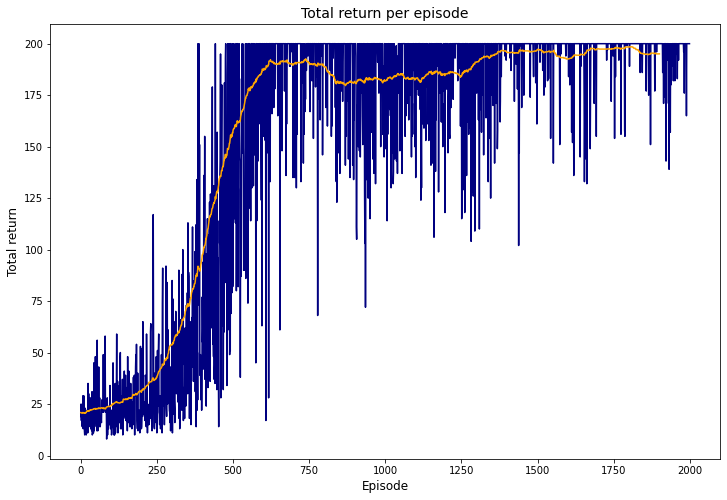

In [142]:
# Average loss per episode
fontsize_title = 14
fontsize_label = 12
plt.figure(figsize=(12, 8))
plt.plot(scores, color='navy');
plt.plot(moving_averages_scores_without_nans, color='orange');
plt.title("Total return per episode", fontsize=fontsize_title)
plt.xlabel('Episode', fontsize=fontsize_label)
plt.ylabel('Total return', fontsize=fontsize_label)
plt.show()

## Save our model

In [143]:
# Specify a path to save the model
PATH = "saved_models/REINFORCE_CartPole_state_dict_model.pt"

# Save
torch.save(policy_est.state_dict(), PATH)

## Load our model

In [6]:
PATH = "saved_models/REINFORCE_CartPole_state_dict_model.pt"
model = policy_estimator();
model.load_state_dict(torch.load(PATH));
model.eval();

## Code to select the best possible action based on our predictions

In [7]:
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index of the item 
    with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top_value = float("-inf")
    ties = []
    
    top_value = max(q_values)
    
    for i in range(len(q_values)):
        # if a value in q_values is greater than the highest value update top and reset ties to zero
        # if a value is equal to top value add the index to ties
        # return a random selection from ties.
        if q_values[i] == top_value:
            ties.append(i)
    
    return np.random.choice(ties)

## Simulation

In [8]:
def random_simulation():
    env = gym.make('CartPole-v1')
    state = env.reset()
    for t in range(500):
        env.render()
        action = np.random.choice(env.action_space.n)
        state, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.close()

In [9]:
random_simulation()

Episode finished after 11 timesteps


In [21]:
def watch_agent():
    env = gym.make('CartPole-v1')
    state = env.reset()
    for t in range(500):
        env.render()
        pred = model.predict(state).detach().numpy()
        action = argmax(pred) # Convert the predictions (Tensor) to numpy array and get best possible action
        state, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.close()

In [23]:
watch_agent()

Episode finished after 500 timesteps
